In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/Exjobb/PSPUnet')

Mounted at /content/drive


In [ ]:
with open 

In [5]:
import numpy as np
import tensorflow as tf
from data_loader import convert_class, data_load
from display import create_mask, show_predictions
from IPython.display import clear_output
from pspunet import pspunet
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import clear_output


IMG_WIDTH = 480
IMG_HEIGHT = 272
n_classes = 10
        
model = pspunet((IMG_HEIGHT, IMG_WIDTH,3), n_classes)


In [6]:
train_dataset, validation_dataset, test_dataset = data_load()

In [4]:
train_size = tf.data.experimental.cardinality(train_dataset)
validation_size = tf.data.experimental.cardinality(validation_dataset)
test_size = tf.data.experimental.cardinality(test_dataset)

print(train_size, validation_size, test_size)

tf.Tensor(4940, shape=(), dtype=int64) tf.Tensor(1646, shape=(), dtype=int64) tf.Tensor(1648, shape=(), dtype=int64)


In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

train_mIoU =tf.keras.metrics.MeanIoU(num_classes = n_classes, name = "train_mIoU")
validation_mIoU =tf.keras.metrics.MeanIoU(num_classes = n_classes, name = "validation_mIoU")
test_mIoU =tf.keras.metrics.MeanIoU(num_classes = n_classes, name = "test_mIoU")

In [8]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '/content/drive/MyDrive/Exjobb/PSPUnet/' + current_time + '/train'
validation_log_dir = '/content/drive/MyDrive/Exjobb/PSPUnet/' + current_time + '/validation'
test_log_dir = '/content/drive/MyDrive/Exjobb/PSPUnet/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
validation_summary_writer = tf.summary.create_file_writer(validation_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [9]:
@tf.function
def train_step(images, label):
    
    with tf.GradientTape() as tape:
        pred_img = model(images)        
        loss =  loss_object(label, pred_img)

    gradients_of_model = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_model, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label, pred_img)

@tf.function
def validation_step(images, label):
    pred_img = model(images)
    loss =  loss_object(label, pred_img)
    
    #pred_mask = tf.argmax(pred_img, axis=-1)
    #pred_mask = pred_mask[..., tf.newaxis]
    
    #test_mIoU(label, pred_mask)
    validation_loss(loss)
    validation_accuracy(label, pred_img)
 
@tf.function
def test_step(images, label):
    pred_img = model(images)
    loss =  loss_object(label, pred_img)
    
    #pred_mask = tf.argmax(pred_img, axis=-1)
    #pred_mask = pred_mask[..., tf.newaxis]
    
    #test_mIoU(label, pred_mask)
    test_loss(loss)
    test_accuracy(label, pred_img)

In [10]:
def train(train_dataset, test_dataset, epochs, batch_size):
    epoch_train_losses = []
    epoch_val_losses = []
    with tf.device('/device:GPU:0'):
      for epoch in range(epochs):
          total_epoch_train_loss = 0
          total_epoch_val_loss = 0
          
          if epoch >=10:
              optimizer = tf.keras.optimizers.Adam(1e-5)

          
          start = time.time()

          train_loss.reset_states()
          train_accuracy.reset_states()    
          
          test_loss.reset_states()
          test_accuracy.reset_states()
                  
          count_img = 0
          batch_time = time.time()
          
          for image_batch, label_batch in train_dataset.batch(batch_size):
              count_img += batch_size
              label_batch = convert_class(label_batch.numpy())
              
              if tf.random.uniform(()) > 0.5:
                  image_batch = tf.image.flip_left_right(image_batch)
                  label_batch = tf.image.flip_left_right(label_batch)

              image_batch = tf.image.random_brightness(image_batch, 0.3)
              
              train_step(image_batch, label_batch)
              
              if count_img % 8 == 0:
                  total_epoch_train_loss += train_loss.result()

                  clear_output(wait=True)
                  show_predictions(image_batch[:3], label_batch[:3], model)      
                  print('epoch {}, step {}, train_acc {}, loss {} , time {}'.format(epoch+1,
                                                                          count_img,
                                                                          train_accuracy.result()*100,
                                                                          train_loss.result(),
                                                                          time.time()- batch_time))
                  train_loss.reset_states()
                  train_accuracy.reset_states()    
                  
                  batch_time = time.time()
                  
          epoch_train_losses.append(total_epoch_train_loss/(count_img/batch_size))
          count_img = 0
          batch_time = time.time()

          for image_batch, label_batch in validation_dataset.batch(batch_size):
              count_img += batch_size
              label_batch = convert_class(label_batch.numpy())
              
              validation_step(image_batch, label_batch)
              
              
              if count_img % 8 == 0:
                  total_epoch_val_loss += validation_loss.result()
                  clear_output(wait=True)
                  show_predictions(image_batch[:3], label_batch[:3], model)
                  print('epoch {}, step {}, test_acc {}, loss {} , time {}'.format(epoch+1,
                                                                          count_img,
                                                                          validation_accuracy.result()*100,
                                                                          validation_loss.result(),
                                                                          time.time()- batch_time))
                  batch_time = time.time()
                  
          epoch_val_losses.append(total_epoch_val_loss/(count_img/batch_size))
                  
          clear_output(wait=True)

          for image_batch, label_batch in validation_dataset.take(3).batch(3):
              label_batch = convert_class(label_batch.numpy())
              show_predictions(image_batch[:3], label_batch[:3], model)        

          print ('Time for epoch {}  is {} sec'.format(epoch + 1, round(time.time()-start),3))

          print ('train_acc {}, loss {} , validation_acc {}, loss {}'.format(train_accuracy.result()*100,
                                                                                  train_loss.result(),
                                                                                  validation_accuracy.result()*100,
                                                                                  validation_loss.result()
                                                                                  ))
          
          path = "/content/drive/MyDrive/Exjobb/PSPUnet/model" + str(validation_loss.result().numpy())+"_epoch_"+str(epoch+1)+".h5" 
          model.save(path)
              
          with train_summary_writer.as_default():
                  tf.summary.scalar('loss', train_loss.result(), step=epoch+1)
                  tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch+1)             
                  tf.summary.scalar('mIoU', train_mIoU.result(), step=epoch)    
                  
          with validation_summary_writer.as_default():
                  tf.summary.scalar('loss', validation_loss.result(), step=epoch+1)
                  tf.summary.scalar('accuracy', validation_accuracy.result(), step=epoch+1)    
                  tf.summary.scalar('mIoU', validation_mIoU.result(), step=epoch)     

      plt.plot(range(1,len(epoch_train_losses)+1),epoch_train_losses)
      plt.plot(range(1, len(epoch_val_losses)+1), epoch_val_losses)
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.show()
      

      print('Finished Training')

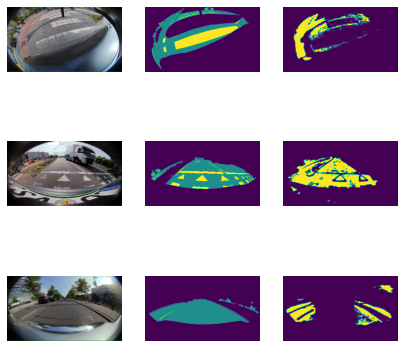

Time for epoch 1  is 6135 sec
train_acc 0.0, loss 0.0 , validation_acc 76.01136779785156, loss 0.6188861727714539


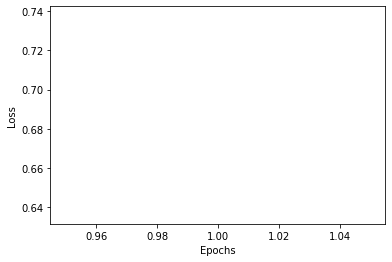

Finished Training


In [11]:
train(train_dataset, validation_dataset, 1, 8)

In [4]:
%load_ext tensorboard
import tensorflow as tf
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=validation_log_dir, histogram_freq=1)

%tensorboard --logdir /content/drive/MyDrive/Exjobb/PSPUnet/20220207-085600/validation

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


NameError: ignored

In [ ]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_18 (Model)                [(None, 16, 16, 256) 14714688    input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 4, 4, 4096)   102764544   model_18[1][2]                   
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 4, 4, 21)     86037       conv2d_170[0][0]                 
___________________________________________________________________________________________

In [ ]:
test_loss.reset_states()
test_accuracy.reset_states()
test_mIoU.reset_states()
model = unet((IMG_HEIGHT, IMG_WIDTH,3), n_classes)
model.load_weights("model_h5/unet/unet_0.35704005_epoch_9.h5")
count_img = 0
batch_time = time.time()

for image_batch, label_batch in test_dataset.batch(8):
    count_img += 8
    label_batch = convert_class(label_batch.numpy())
    
    test_step(image_batch, label_batch)
            
    if count_img % 1000 == 0:
        clear_output(wait=True)
        show_predictions(image_batch[:3], label_batch[:3], model)
        print('epoch {}, step {}, test_acc {}, loss {} ,mIoU {}, time {}'.format(1,
                                                                count_img,
                                                                test_accuracy.result()*100,
                                                                test_loss.result(),
                                                                test_mIoU.result(),
                                                                time.time()- batch_time))
        batch_time = time.time()

In [ ]:
print('epoch {}, step {}, test_acc {}, loss {} ,mIoU {}, time {}'.format(1,
                                                                count_img,
                                                                test_accuracy.result()*100,
                                                                test_loss.result(),
                                                                test_mIoU.result(),
                                                                time.time()- batch_time))

epoch 1, step 12800, test_acc 0.0, loss 0.0 ,mIoU 0.708968997001648, time 383.49503445625305


In [ ]:
count_img

12800